# 1 - Building a model in Azure ML - Notebook

Clonned Wednesday's notebook and commented out

In [30]:
# we are using Azure Machine Learning Dataset: a unified interface to access your data for Machine Learning
# this will be important later on, where we use same dataset for visual ML

from azureml.core import Workspace, Dataset
from azureml.core.authentication import ServicePrincipalAuthentication


service_principal = ServicePrincipalAuthentication(
    tenant_id="502f2f1d-000c-410d-9d65-de9b3cfa9a83",
    service_principal_id="5203e379-a33a-4aea-bd8d-20bef410cc72",
    service_principal_password="9~by7nEl35Zv-3lntYqwm7b-15~ulIWHmw")


ws = Workspace(
    subscription_id='f9f80119-dbb0-496f-8e2c-351e0b95b66e',
    resource_group='bupa_demo',
    workspace_name='bupa_demo',
    auth=service_principal)

print("Found workspace {} at location {}".format(ws.name, ws.location))


dataset = Dataset.get_by_name(ws, name='car_and_health_insurance_cross_sell')
df = dataset.to_pandas_dataframe()
display(df)

Found workspace bupa_demo at location australiaeast


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Claims_Amount,Claims_Num
0,1,Male,47,1,28.0,0,> 2 Years,Yes,2753.018174,26.0,217,1,311,17
1,2,Male,79,1,3.0,0,1-2 Year,No,2282.227159,26.0,183,0,48,2
2,3,Male,50,1,28.0,0,> 2 Years,Yes,2606.023581,26.0,27,1,507,33
3,4,Male,24,1,11.0,1,< 1 Year,No,1947.610301,152.0,203,0,0,0
4,5,Female,32,1,41.0,1,< 1 Year,No,1871.186724,152.0,39,0,435,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,77,1,26.0,1,1-2 Year,No,2053.160585,26.0,88,0,29,1
381105,381106,Male,33,1,37.0,1,< 1 Year,No,2723.210937,152.0,131,0,0,0
381106,381107,Male,24,1,30.0,1,< 1 Year,No,2389.887088,160.0,161,0,0,0
381107,381108,Female,71,1,14.0,0,> 2 Years,Yes,3036.323031,124.0,74,0,14,1


In [31]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=65)

print('Dataset sizes:')
print(f'\t->df_train size={df_train.shape[0]}')
print(f'\t->df_test size={df_test.shape[0]}')

Dataset sizes:
	->df_train size=304887
	->df_test size=76222


# 1. Quick EDA

In [32]:
# !pip install seaborn plotly

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd

Looks like the most useful features to predict `Response` are:
- `Age`
- `Previously_Insured`
- `Policy_Sales_Channel`
- `Claimns_Amount`
- `Claims_Num`

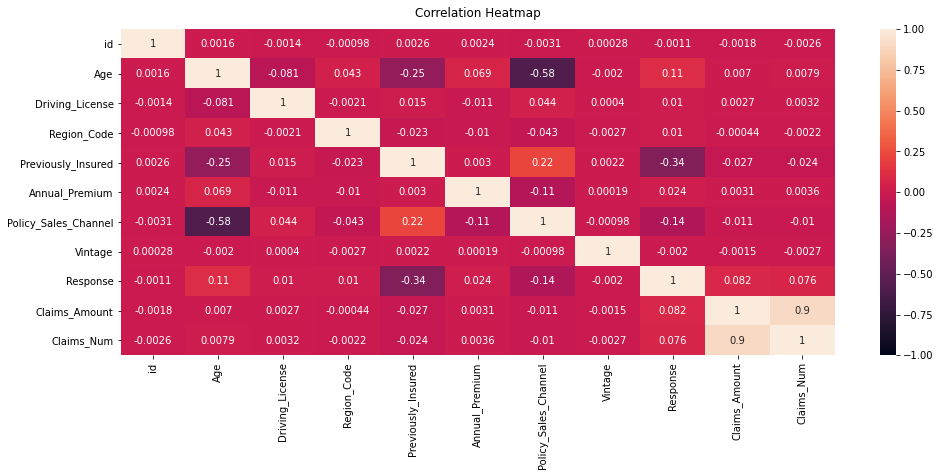

In [34]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

It looks like we are dealing with imbalanced dataset. `1` has 46.7k samples vs `0` 334.4k

In [35]:
display(df.groupby('Response').count()[['id']])

,id
Response,
0,334399
1,46710


In [36]:
response_1 = df_train[df_train['Response'] == 1]
response_0 = df_train[df_train['Response'] == 0]

df_train_balanced = pd.concat([response_1, response_0.sample(response_1.shape[0])])

In [37]:
correlated_features = ['Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Claims_Amount', 'Claims_Num']
# dbutils.widgets.dropdown('correlated_features', correlated_features[0], correlated_features)

In [40]:
fig = px.histogram(df_train_balanced.sample(10000), x=correlated_features, marginal='box', color='Response')
fig.show()

In [21]:
import cloudpickle as pickle
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Baseline Model

### 2.1 Defining model structure

In [47]:
class BaselineModel():
    def __init__(self, random_forest_params={}, feature_columns=None):
        self._random_forest_params = random_forest_params
        self._feature_columns = feature_columns

    def fit(self, X, y):
        _X = copy.deepcopy(X)
        _X = _X[self._feature_columns]
        self._scaler = MinMaxScaler().fit(_X)
        _X = self._scaler.transform(_X)

        self._rf = RandomForestClassifier(**self._random_forest_params)
        self._rf.fit(_X, y)
        return self

    def predict(self, context, X):
        _y = self._predict(X)
        return _y 

    def _predict(self, X):
        _X = copy.deepcopy(X)
        _X = _X[self._feature_columns]
        _X = self._scaler.transform(_X)
        _y = self._rf.predict(_X)
        return _y

    def load_context(self, context):
        # this is where we define how to load "components" of the model
        with open(context.artifacts['feature_cols'], 'rb') as f:
            self._feature_columns = json.load(f)



# 3. (Hopefully) better models
Our baseline model is pretty bad. Let's see if we can create a better one by adding new features & changing algorithms.

In [49]:
display(df_train)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Claims_Amount,Claims_Num
359892,359893,Male,35,1,35.0,1,< 1 Year,No,2749.819681,152.0,222,0,39,2
354861,354862,Male,61,1,28.0,0,> 2 Years,Yes,1628.237327,26.0,277,0,209,4
181207,181208,Male,61,1,28.0,0,1-2 Year,Yes,4167.024493,26.0,168,1,5873,159
348838,348839,Female,27,1,35.0,0,< 1 Year,Yes,2286.174236,152.0,147,0,70,1
122024,122025,Female,42,1,33.0,0,1-2 Year,Yes,178.979527,156.0,265,0,113,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216391,216392,Male,24,1,30.0,1,< 1 Year,No,2145.440524,160.0,273,0,27,1
68309,68310,Male,29,1,28.0,0,< 1 Year,Yes,3883.107159,26.0,286,0,0,0
131647,131648,Female,47,1,48.0,0,1-2 Year,Yes,178.979527,156.0,211,0,174,11
272501,272502,Male,44,1,3.0,0,1-2 Year,Yes,1995.791862,124.0,112,0,51,1


## Getting Features

In [52]:
def gender_encoder(df, use_prefix=False):
    _mapping = {'Male': 0, 'Female': 1}

    new_col = 'Gender'
    if use_prefix:
        new_col = 'x_Gender' 

    df[new_col] = df['Gender'].apply(lambda x: _mapping[x])
    return df


def vehicle_age_encoder(df, use_prefix=False):
    _mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

    new_col = 'Vehicle_Age'
    if use_prefix:
        new_col = 'x_Vehicle_Age' 

    df[new_col] = df['Vehicle_Age'].apply(lambda x: _mapping[x])
    return df


def vehicle_damage_encoder(df, use_prefix=False):
    _mapping = {'No': 0, 'Yes': 1}

    new_col = 'Vehicle_Damage'
    if use_prefix:
        new_col = 'x_Vehicle_Damage' 

    df[new_col] = df['Vehicle_Damage'].apply(lambda x: _mapping[x])
    return df


funcs = [
  gender_encoder,
  vehicle_age_encoder,
  vehicle_damage_encoder,
]

for f in funcs:
    df_train = f(df_train, True)
    df_test = f(df_test, True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [54]:
features = [
  'Age', 
  'Previously_Insured',
  'Policy_Sales_Channel',
  'Claims_Amount',
  'Claims_Num',
  'Driving_License',
  'Region_Code',
  'Annual_Premium',
  'Vintage',
  'x_Gender',
  'x_Vehicle_Age',
  'x_Vehicle_Damage'
]

label = 'Response'

X_train = df_train[features]
y_train = df_train[label]

X_test = df_test[features]
y_test = df_test[label]

## Let's try XGboost

<img src= "https://machinelearningapplied.com/wp-content/uploads/2019/10/xgboost_logo.png" width=300 align="left" style="margin-top:30px;margin-bottom:30px">

XGBoost is a powerful algorithm that works very well out of the box. It is the closest thing to silver bullet in Machine Learning right now for any tabular datasets.

In [255]:
import xgboost as xgb

In [256]:
# Looks promising, let's keep experimenting

params = {
  'max_depth': 2, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.07204495283965483


In [257]:
params = {
  'max_depth': 3, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.14000187670076006


In [258]:
params = {
  'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.18290827740492172


In [259]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

#evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
roc=roc_auc_score(y_test,y_pred)

print("\n**** Model performance ****\n")
print("Accuracy:  %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%% " % (precision *100))
print("Recall:    %.2f%% " % (recall * 100))
print("AUC:       %.2f%% " % (roc *100))
print("F1 Test:   %.4f" % (f1_test))
print()


**** Model performance ****

Accuracy:  88.02%
Precision: 56.94% 
Recall:    10.90% 
AUC:       54.87% 
F1 Test:   0.1829



## A small Neural Network with Keras (and tensorflow)


<img src="https://keras.io/img/logo.png" width=300 align="left" style="margin-top:30px;margin-bottom:30px">

In [260]:
from tensorflow.keras import models, layers

In [261]:
X_mean = np.mean(X_train.values,axis=0)
X_std = np.std(X_train.values,axis=0)
print(X_mean.shape)

(12,)


In [262]:
X_train_tf = (X_train.values - X_mean) / X_std
X_test_tf = (X_test.values - X_mean) / X_std 

In [263]:
print(X_mean)

[4.18253582e+01 4.57874557e-01 1.12003001e+02 2.36959178e+02
 9.61829465e+00 9.97828704e-01 2.63994792e+01 2.08020657e+03
 1.54243674e+02 4.59560427e-01 6.09927613e-01 5.05029732e-01]


In [264]:
model = models.Sequential()
model.add(layers.Dense(256, input_dim=X_train.values.shape[1], activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 256)               3328      
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_57 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 65        
Total params: 48,705
Trainable params: 48,705
Non-trainable params: 0
_________________________________________________________________


In [265]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [266]:
history = model.fit(X_train_tf, y_train.values, validation_split=.2, epochs=10, batch_size=256)

Train on 243909 samples, validate on 60978 samples
Epoch 1/10
243909/243909 [==============================] - 3s 14us/sample - loss: 0.2698 - accuracy: 0.8776 - val_loss: 0.2620 - val_accuracy: 0.8801
Epoch 2/10
243909/243909 [==============================] - 3s 12us/sample - loss: 0.2622 - accuracy: 0.8799 - val_loss: 0.2606 - val_accuracy: 0.8799
Epoch 3/10
243909/243909 [==============================] - 3s 12us/sample - loss: 0.2614 - accuracy: 0.8801 - val_loss: 0.2634 - val_accuracy: 0.8794
Epoch 4/10
243909/243909 [==============================] - 3s 12us/sample - loss: 0.2611 - accuracy: 0.8803 - val_loss: 0.2597 - val_accuracy: 0.8802
Epoch 5/10
243909/243909 [==============================] - 3s 12us/sample - loss: 0.2604 - accuracy: 0.8804 - val_loss: 0.2600 - val_accuracy: 0.8800
Epoch 6/10
243909/243909 [==============================] - 3s 12us/sample - loss: 0.2601 - accuracy: 0.8807 - val_loss: 0.2598 - val_accuracy: 0.8800
Epoch 7/10
243909/243909 [=================

In [267]:
import numpy as np
y_result = model.predict(X_test_tf)
y_result = np.reshape(y_result,y_result.shape[0])
print(y_result.shape)

(76222,)


In [268]:
y_pred = np.array([0 if a < .5 else 1 for a in y_result])
print(y_pred.shape)

(76222,)


In [269]:
print(y_pred[:10])

[0 0 0 0 0 0 0 0 0 0]


In [270]:
f1_test = f1_score(y_test.values, y_pred)

In [271]:
print(f1_test)

0.18429973238180197


In [272]:
#evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
roc=roc_auc_score(y_test,y_pred)

print("\n**** Model performance ****\n")
print("Accuracy:  %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%% " % (precision *100))
print("Recall:    %.2f%% " % (recall * 100))
print("AUC:       %.2f%% " % (roc *100))
print("F1 Test:   %.4f" % (f1_test))
print()


**** Model performance ****

Accuracy:  88.00%
Precision: 56.45% 
Recall:    11.01% 
AUC:       54.91% 
F1 Test:   0.1843

